Elad Inbar - 205358211
Ido Livne - 203834733

Our work will be using the dataset:

•	https://www.kaggle.com/jessicali9530/stanford-cars-dataset 

# **Import**

In [1]:
# Download dataset and initialize runtime
import torch

# Define Image Paths
import os

# Exploratory Data Analysis
import cv2
import matplotlib.pyplot as plt

# Pre-Processing
import numpy as np
import scipy.io as sio 
import tensorflow as tf
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.transforms.functional import resize
import random
from imgaug import augmenters as iaa

# Forming the neural network
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

# Adding Inference-Time-Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tqdm import tqdm

/home/eladin/.conda/envs/my_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Download dataset and initialize runtime**



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r "/content/drive/My Drive/Deep Learning/kaggle.json" "/content"

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset -p content/stanford-cars-dataset/ --unzip

In [ ]:
!cp -r "/content/drive/My Drive/Deep Learning/cars_train_extra" "/content/stanford-cars-dataset"
!cp -r "/content/drive/My Drive/Deep Learning/devkit" "/content/stanford-cars-dataset"

Here we create a new directory that will include the original cropped samples. It will also be the default path for the dataset object. 

In [ ]:
# Cropped train image folder
!mkdir content/stanford-cars-dataset/cropped_train
!mkdir content/stanford-cars-dataset/cropped_train/cropped_train

# Cropped test image folder
!mkdir content/stanford-cars-dataset/cropped_test
!mkdir content/stanford-cars-dataset/cropped_test/cropped_test

Here we create a new directory to include the augmented (processed) images. We will use this directory to store the original cropped samples along with their augmentations, which will serve us during our 'Third Try' (train samples) and during Inference-Time-Augmentation (test samples).

In [ ]:
# Processed train image folder
!mkdir content/stanford-cars-dataset/processed_train
!mkdir content/stanford-cars-dataset/processed_train/processed_train

# Processed test image folder
!mkdir content/stanford-cars-dataset/processed_test
!mkdir content/stanford-cars-dataset/processed_test/processed_test

In [ ]:
# Extra train image folder
!mkdir content/stanford-cars-dataset/cars_train_extra
!mkdir content/stanford-cars-dataset/cars_train_extra/cars_train_extra/

# Extra test image folder
!mkdir /content/stanford-cars-dataset/cars_test_extra
!mkdir /content/stanford-cars-dataset/cars_test_extra/cars_test_extra

# **Define image paths**

In [3]:
train_annos_path = 'content/stanford-cars-dataset/devkit/cars_train_annos.mat'
test_annos_path = 'content/stanford-cars-dataset/devkit/cars_test_annos_withlabels.mat'

train_path = 'content/stanford-cars-dataset/cars_train/cars_train/'
test_path = 'content/stanford-cars-dataset/cars_test/cars_test/'

extra_train_path = 'content/stanford-cars-dataset/cars_train_extra/cars_train_extra/'
extra_test_path = 'content/stanford-cars-dataset/cars_test_extra/cars_test_extra/'

processed_train_path = 'content/stanford-cars-dataset/processed_train/processed_train/'
processed_test_path = 'content/stanford-cars-dataset/processed_test/processed_test/'

cropped_train_path = 'content/stanford-cars-dataset/cropped_train/cropped_train/'
cropped_test_path = 'content/stanford-cars-dataset/cropped_test/cropped_test/'

y_train_labels_path = 'content/stanford-cars-dataset/y_train_labels.csv'
y_test_labels_path = 'content/stanford-cars-dataset/y_test_labels.csv'

train_dir = sorted(os.listdir(train_path))
test_dir = sorted(os.listdir(test_path))

# **Exploratory Data Analysis**

After downloading the dataset we can check how much data we're working with:

In [4]:
print("Training data samples: ", len(train_dir))
print("Testing data samples: ", len(test_dir))
print("Entire dataset samples: ", len(train_dir) + len(test_dir))

Training data samples:  8144
Testing data samples:  8041
Entire dataset samples:  16185


In [5]:
def load_img(path):
    image = cv2.imread(path)
    return image[...,::-1]

We can now test the dimensions of our images.

In [6]:
print(f"Image '{train_dir[0]}' has the following shape: {load_img(train_path + train_dir[0]).shape}")
print(f"Image '{train_dir[1]}' has the following shape: {load_img(train_path + train_dir[1]).shape}")

Image '00001.jpg' has the following shape: (400, 600, 3)
Image '00002.jpg' has the following shape: (675, 900, 3)


From these results we can conclude that the dimensions of each sample are different and that we are working with RGB type images.

Therefore, our data will require some pre-processing to streamline our input so that our model will be able to work and adapt to a fixed image size.

The data is also in .jpg format, so we will first have to convert the images to tensors that our model will know how to work with.

We would now like to obtain the different classes our data will belong to and figure out how many classes our model will have to get acquainted with:

In [7]:
def get_classes():
  cars_meta = sio.loadmat('content/stanford-cars-dataset/devkit/cars_meta.mat')
  return cars_meta['class_names'][0]

classes = [class_list[0] for class_list in get_classes()]
print("Classes size: ", len(classes))

Classes size:  196


Classes are typically defined as 'Make Model Year'.

So for example a class can be defined as following:


In [8]:
print("Class example: ", classes[10])

Class example:  Aston Martin Virage Coupe 2012


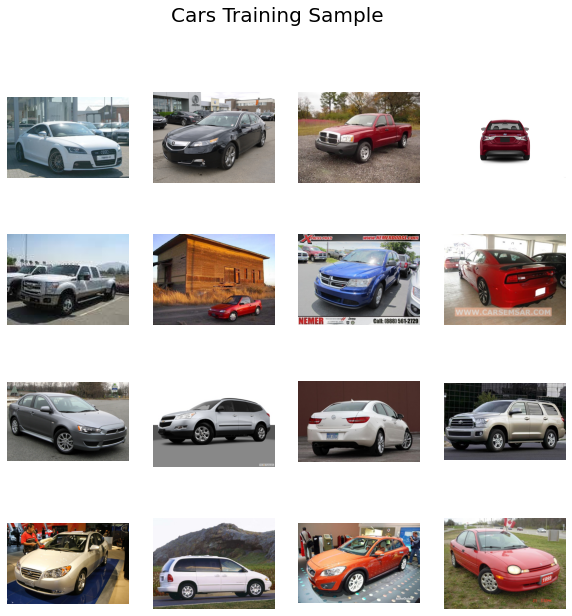

In [9]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_path + train_dir[i]), cmap='gray')
    plt.suptitle("Cars Training Sample", fontsize=20)
    plt.axis('off')

plt.show()

# **Pre-Processing**

## Pre Processing images

The data we got already defines the bounding box (bbox) of each of the images. Here we will extract the bbox definitions to crop the image later.

In [10]:
def process_img_data(path):
    cars_annos = sio.loadmat(path)
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    return fnames, bboxes

### Resize image function
As has been mentioned before, our images have different sizes and dimensions. In order to work with them we will have to resize them all to a common size.
Using the bboxes mentioned earlier we will also crop the images to reduce the noise while still leaving a small margin.

In [11]:
picture_dim = (3, 224, 224)

def resize_images(path, annos, path_to_save, crop=True):
    image_names = sorted(os.listdir(path))

    if crop:
      _, bboxes = process_img_data(annos)

    for idx in range(len(image_names)):      
      image_name = image_names[idx]
      im = cv2.imread(path + "/" + image_name)[:,:,::-1]

      if crop:
        (x1, y1, x2, y2) = bboxes[idx]
        height, width = im.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        im = im[y1:y2, x1:x2]

      channels, h_resize ,w_resize = picture_dim   

      im = cv2.resize(im, (h_resize,w_resize), interpolation=cv2.INTER_LINEAR)

      im = im.astype(np.float32)
      cv2.imwrite(path_to_save + "/" + image_name, im)
  

In [12]:
if sum(len(files) for _, _, files in os.walk(cropped_train_path)) < sum(len(files) for _, _, files in os.walk(train_path)):
    resize_images(train_path, train_annos_path, cropped_train_path)
if sum(len(files) for _, _, files in os.walk(cropped_test_path)) < sum(len(files) for _, _, files in os.walk(test_path)):    
    resize_images(test_path, test_annos_path, cropped_test_path)

Here we can see the new image size:

In [13]:
image_names = sorted(os.listdir(cropped_train_path))
image_name = image_names[0]
im = cv2.imread(cropped_train_path + "/" + image_name)
im.shape

(224, 224, 3)

### Creating labels

In [14]:
def process_img_class(path):
    cars_annos = sio.loadmat(path)
    annotations = cars_annos['annotations'][0]

    classes = []

    for annotation in annotations:
        tag = annotation[4][0][0]-1
        classes.append(tag)

    return classes

In [15]:
y_train_labels = process_img_class(train_annos_path)
y_test_labels = process_img_class(test_annos_path)


Writing labels to a csv file

In [16]:
df_train = pd.DataFrame(y_train_labels)
df_train.to_csv(path_or_buf=y_train_labels_path, index=False)

df_test = pd.DataFrame(y_test_labels)
df_test.to_csv(path_or_buf=y_test_labels_path, index=False)

In [17]:
def read_label(path,idx):
  label = pd.read_csv(path)
  label = label.iloc[idx, 0]
  return label

## Train Data Balance

Now that we have our ground truth established we can test whether the data is balanced:

<BarContainer object of 196 artists>

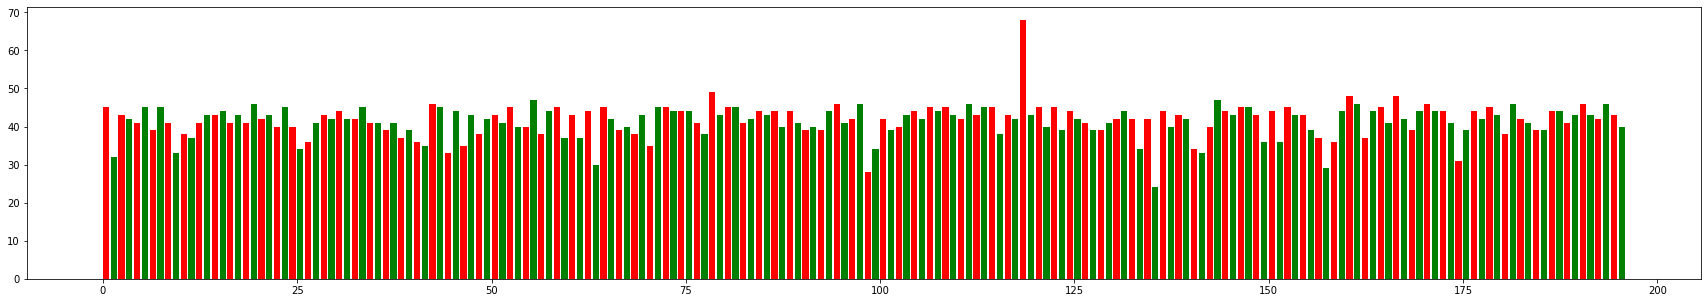

In [18]:
from collections import Counter

sorted_classes = sorted(y_train_labels)

x_values = list(Counter(sorted_classes).keys())
y_values = list(Counter(sorted_classes).values())

fig = plt.figure(figsize=[30,5])

plt.bar(x_values, y_values, figure=fig, align='edge', color=['red', 'green'])

## Test Data Balance

<BarContainer object of 196 artists>

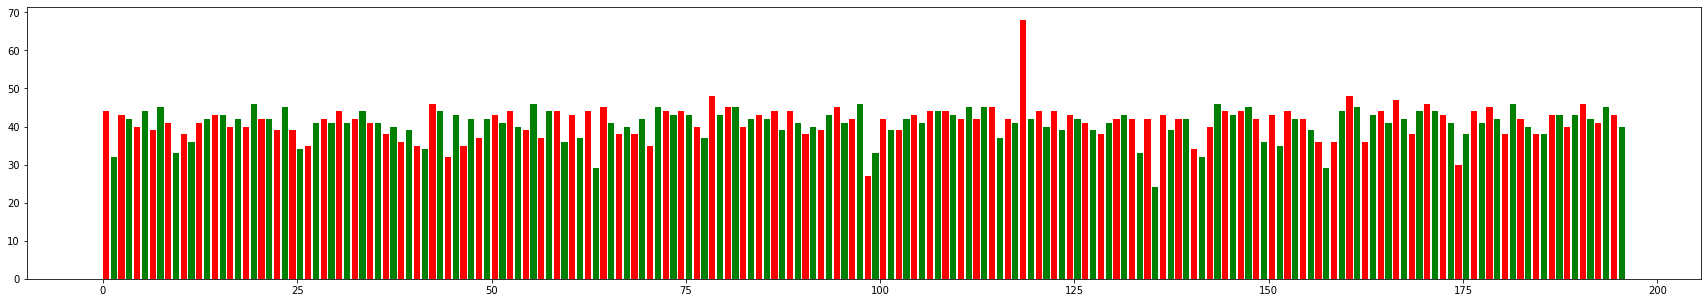

In [19]:
from collections import Counter

sorted_classes = sorted(y_test_labels)

x_values = list(Counter(sorted_classes).keys())
y_values = list(Counter(sorted_classes).values())

fig = plt.figure(figsize=[30,5])

plt.bar(x_values, y_values, figure=fig, align='edge', color=['red', 'green'])



From the results we can establish that each class has a balanced representation in the dataset samples, which will assist our model's convergence.

## Benchmark results

There are various benchmarks for this dataset, some of them include:

https://www.kaggle.com/code/meaninglesslives/cars-se-resnext50-fastai
That displays a 92% test accuracy and utilizes ResNeXt pretrained models.

https://www.kaggle.com/code/meaninglesslives/cars-eb3-keras
Reports a 90% test accuracy and is based upon EfficientNet pretrained on ImageNet.

https://www.kaggle.com/code/meaninglesslives/cars-eb0-keras
Reports a 90% test accuracy and is based upon EfficientNetB0 pretrained on ImageNet.

https://www.kaggle.com/code/abdelrahmant11/car-type-classification
Peaks with 21% validation accuracy using a model with 3 convolution layers containing 1 convolution+max pooling each and a dense+dropout layer.


## Create the dataset object

In [20]:
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image

class cars_dataset(Dataset):
    def __init__(self, path_to_imgs, labels_path, transform=None, target_transform=None):
        ## assumptions:
        ## labels_file contains filename and label for that file
        self.labels_path = labels_path
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        data = pd.read_csv(self.labels_path)
        return data.size
    
    def __getitem__(self,idx):
        image_name = sorted(os.listdir(self.path_to_imgs))[idx]
        im = cv2.imread(self.path_to_imgs + "/" + image_name)[:,:,::-1]
        # channels need to be first (channel x height x width)
        im = im.transpose()
        label = read_label(self.labels_path, idx)
        if self.transform:
            im = self.transform(im)
        if self.target_transform:
            label = self.target_transform(label)
        return im.astype(np.float32).copy(), label

In [21]:
cropped_cars_train_dataset = cars_dataset(cropped_train_path, y_train_labels_path)
cropped_cars_test_dataset = cars_dataset(cropped_test_path, y_test_labels_path)
im, label = cropped_cars_train_dataset.__getitem__(0)
print("image shape:{shape} label: {label}".format(shape = im.shape, label = label))

image shape:(3, 224, 224) label: 13


## Create KFolds

In [22]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=False)


# **Forming the neural network**

## Preparing common functions and variables

In [23]:
epochs = 15
batch_size = 8

In [24]:
def train_loop(data_loader, model, device, loss_fn, optimizer, print_every_n=100):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    true_positives=0
    for batch, (X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(dtype=torch.long)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        true_positives += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%print_every_n==0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss={loss:.3f}, {current} samples / {size}')
        
    train_loss /= num_batches
    train_acc = true_positives/size    
    print(f'train accuracy = {train_acc:.8f}')

    return train_loss, train_acc

def test_loop(data_loader, model, device, loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0
    true_positives=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            true_positives += (y==pred.argmax(1)).type(torch.float).sum().item()
        
    test_loss /= num_batches
    test_acc = true_positives/size
    print(f'test accuracy = {test_acc}, test loss = {test_loss:2f}')
    return test_loss, test_acc

## Setting Model Train Function

In [25]:
def train_and_validate_kfold(model, dataset, epochs, batch_size, learning_rate, loss_fn): 
  model_history = []
  for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    print("fold number: " + str(fold+1))
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    current_history = []
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
    for epoch in range(epochs):
      print("epoch: ", epoch+1, "/", epochs)
      train_loss, train_acc = train_loop(train_loader, model, device, loss_fn, optimizer)
      test_loss, test_acc = test_loop(val_loader, model, device, loss_fn)
      current_history.append({'train_loss':train_loss.detach().cpu().numpy(), 'val_loss':test_loss, 'train_acc':train_acc, 'val_acc':test_acc})
      print()
    model_history.append(current_history)
    # Reset fold model weights after acquiring all relevant metrics
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()

  return model_history

In [26]:
def get_mean_history(model_history, fold_count):
  history = [{'train_loss':0, 'val_loss':0, 'train_acc':0, 'val_acc':0} for i in range(epochs)]
  for fold in range(fold_count):
    for epoch in range(epochs):
      history[epoch]['train_loss'] += model_history[fold][epoch]['train_loss']
      history[epoch]['val_loss'] += model_history[fold][epoch]['val_loss']
      history[epoch]['train_acc'] += model_history[fold][epoch]['train_acc']
      history[epoch]['val_acc'] += model_history[fold][epoch]['val_acc']

  for epoch in range(epochs):
      history[epoch]['train_loss'] /= fold_count
      history[epoch]['val_loss'] /= fold_count
      history[epoch]['train_acc'] /= fold_count  
      history[epoch]['val_acc'] /= fold_count
  return history


### Setting plot functions

In [27]:
def plot_accuracy(epochs, history):
  x_axis = list(range(epochs))
  acc_res = [history[i]['train_acc'] for i in range(epochs)]
  test_res = [history[i]['val_acc'] for i in range(epochs)]
  plt.plot(x_axis, acc_res, label = "train accuracy")
  plt.plot(x_axis, test_res, label = "validation accuracy")

  # naming the x axis
  plt.xlabel('epochs')
  # naming the y axis
  plt.ylabel('accuracy')
    
  # show a legend on the plot
  plt.legend()
    
  # function to show the plot
  plt.show()

In [67]:
def plot_loss(epochs, history):
  x_axis = list(range(epochs))
  train_loss_res = [history[i]['train_loss'].item(0) for i in range(epochs)]
  val_loss_res = [history[i]['val_loss'] for i in range(epochs)]
  plt.plot(x_axis, train_loss_res, label = "train loss")
  plt.plot(x_axis, val_loss_res, label = "validation loss")

  # naming the x axis
  plt.xlabel('epochs')
  # naming the y axis
  plt.ylabel('loss')
    
  # show a legend on the plot
  plt.legend()
    
  # function to show the plot
  plt.show()

## First Try

### Defining the architecture

We start out with a basic architecture structure:

In [29]:
class ConvNetV1(nn.Module):
    def __init__(self, in_channels, in_height, in_width, max_pool_count):
        super(ConvNetV1, self).__init__()
        out_width = int(in_width / (2**max_pool_count))
        out_height = int(in_height / (2**max_pool_count))
        out_channels = 64
        self.flattened_dimensions = out_channels * out_width * out_height

        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(self.flattened_dimensions, 500)
        self.fc2 = nn.Linear(500, 196)

        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):        
        # add sequence of convolutional and max pooling layers
        x = self.relu(self.conv1(x)) # 3->64
        x = self.relu(self.conv2(x)) # 64->64
        x = self.relu(self.conv3(x)) # 64->64

        # max pooling
        x = self.pool(x)
       
        # flatten image input
        x = x.view(-1, self.flattened_dimensions)

        # add dropout layer
        x = self.dropout(x)
        # fully connected
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

channels, height, width = picture_dim
model = ConvNetV1(channels, height, width, 1).to(device)

learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
epochs = 5

### Results

In [30]:
model_history = train_and_validate_kfold(model, cropped_cars_train_dataset, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

fold number: 1
epoch:  1 / 5
loss=7.003, 0 samples / 8144
loss=5.189, 800 samples / 8144
loss=5.292, 1600 samples / 8144
loss=5.345, 2400 samples / 8144
loss=5.286, 3200 samples / 8144
loss=5.264, 4000 samples / 8144
loss=5.324, 4800 samples / 8144
loss=5.255, 5600 samples / 8144
loss=5.303, 6400 samples / 8144
train accuracy = 0.00540275
test accuracy = 0.0018418467583497054, test loss = 5.247810

epoch:  2 / 5
loss=4.643, 0 samples / 8144
loss=4.091, 800 samples / 8144
loss=4.377, 1600 samples / 8144
loss=2.860, 2400 samples / 8144
loss=3.209, 3200 samples / 8144
loss=3.604, 4000 samples / 8144
loss=3.280, 4800 samples / 8144
loss=4.338, 5600 samples / 8144
loss=3.615, 6400 samples / 8144
train accuracy = 0.15839882
test accuracy = 0.007490176817288801, test loss = 5.373935

epoch:  3 / 5
loss=1.321, 0 samples / 8144
loss=0.825, 800 samples / 8144
loss=0.333, 1600 samples / 8144
loss=0.556, 2400 samples / 8144
loss=0.034, 3200 samples / 8144
loss=0.001, 4000 samples / 8144
loss=0.000

In [52]:
history = get_mean_history(model_history, k_folds)

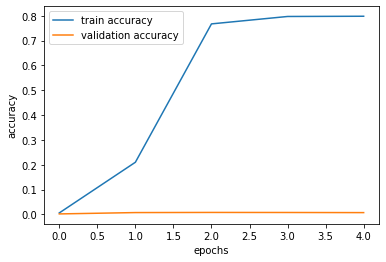

In [54]:
plot_accuracy(epochs, history)

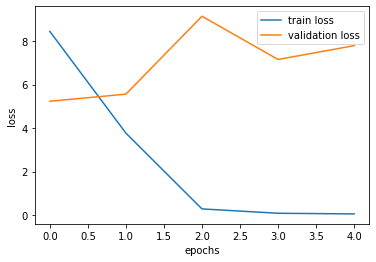

In [55]:
plot_loss(epochs, history)

In [56]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,8.448141,5.232834,0.006164,0.002186
1,3.768009,5.560604,0.210241,0.007588
2,0.281176,9.143803,0.767362,0.008153
3,0.080759,7.155322,0.797200,0.007932
4,0.051019,7.790699,0.798134,0.007441


From the results we gather that our model is overfitting and not generalizing the input enough but rather memorizing it.

Since our model is overfitting we can try:

1.   Adding another dropout layer and convolution layers with less convolutions per layer to increase the amount of channels the model uses to analyze the input.


2.   Adding augmented samples to make it harder for our model to "just" memorize all the samples and to try and "force" it to generalize the input data more.


3. Adding an additional fully connected layer with more output channels to ensure our output is more specific to the input features before moving them on to the final prediction fully connected layer.



## Second Try

### Defining the architecture

In [29]:
class ConvNetV2(nn.Module):
    def __init__(self, in_channels, in_height, in_width, max_pool_count):
        super(ConvNetV2, self).__init__()
        out_height = int(in_height / (2**max_pool_count))
        out_width = int(in_width / (2**max_pool_count))
        out_channels = 256
        self.flattened_dimensions = out_channels * out_height * out_width
        
        # layers
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv21 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv22 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv31 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv32 = nn.Conv2d(256, 256, 3, padding=1)

        self.fc1 = nn.Linear(self.flattened_dimensions, 2000)
        self.fc3 = nn.Linear(2000, 1000)
        self.fc2 = nn.Linear(1000, 196)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 1st convolution
        x = self.relu(self.conv1(x)) # 3->64
        x = self.relu(self.conv2(x)) # 64->64

        # max pool
        x = self.pool(x)

        # 2nd convolution
        x = self.relu(self.conv21(x)) # 64->128
        x = self.relu(self.conv22(x)) # 128->128

        # max pool
        x = self.pool(x)

        # 3rd convolution
        x = self.relu(self.conv31(x)) # 128->256
        x = self.relu(self.conv32(x)) # 256->256

        # max pool
        x = self.pool(x)

        # flatten image input
        x = x.view(-1, self.flattened_dimensions)

        # dropout
        x = self.dropout(x)
        # 1st fully connected
        x = self.relu(self.fc1(x))
        # dropout
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        # 2nd fully connected
        x = self.fc2(x)

        return x

channels, height, width = picture_dim
model = ConvNetV2(channels, height, width, 3).to(device)

learning_rate = 5e-6
loss_fn = nn.CrossEntropyLoss()

epochs = 8

### Results

In [30]:
model_history = train_and_validate_kfold(model, cropped_cars_train_dataset, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

fold number: 1
epoch:  1 / 8
loss=5.249, 0 samples / 8144
loss=5.350, 800 samples / 8144
loss=5.284, 1600 samples / 8144
loss=5.353, 2400 samples / 8144
loss=5.270, 3200 samples / 8144
loss=5.292, 4000 samples / 8144
loss=5.268, 4800 samples / 8144
loss=5.269, 5600 samples / 8144
loss=5.295, 6400 samples / 8144
train accuracy = 0.00380648
test accuracy = 0.0013506876227897839, test loss = 5.246530

epoch:  2 / 8
loss=5.246, 0 samples / 8144
loss=5.008, 800 samples / 8144
loss=5.304, 1600 samples / 8144
loss=5.399, 2400 samples / 8144
loss=5.099, 3200 samples / 8144
loss=5.189, 4000 samples / 8144
loss=5.226, 4800 samples / 8144
loss=5.097, 5600 samples / 8144
loss=5.097, 6400 samples / 8144
train accuracy = 0.01191061
test accuracy = 0.003806483300589391, test loss = 5.149503

epoch:  3 / 8
loss=5.206, 0 samples / 8144
loss=5.286, 800 samples / 8144
loss=5.106, 1600 samples / 8144
loss=4.146, 2400 samples / 8144
loss=5.157, 3200 samples / 8144
loss=5.233, 4000 samples / 8144
loss=4.991

In [31]:
history = get_mean_history(model_history, k_folds)

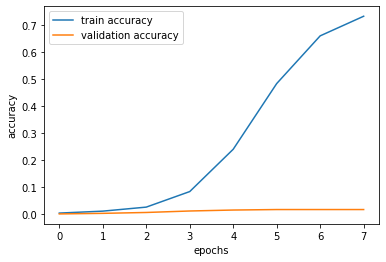

In [32]:
plot_accuracy(epochs, history)

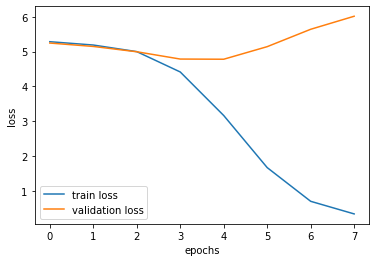

In [33]:
plot_loss(epochs, history)

In [34]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,5.282546,5.244163,0.004862,0.001793
1,5.187188,5.146604,0.012083,0.003905
2,4.997819,4.993814,0.026989,0.007146
3,4.413397,4.784165,0.084602,0.012623
4,3.162488,4.779169,0.241356,0.016159
5,1.666070,5.140467,0.484700,0.017976
6,0.697827,5.639473,0.661444,0.017976
7,0.335619,6.014058,0.734111,0.017976


From the results we gather that although our model is still overfitting, the validation accuracy has still improved substantially.

Since our model is overfitting we can try:

1. Adding more dropout layers in between convolution layers.

2. Decreasing the amount of convolutions per layer and add an additional convolution layer with dropout layers in between.

3. Decreasing the learning rate which may have caused us to "jump" over the absolute minimum leading to the best model convergence.

## Third Try

### Defining the architecture

In [ ]:
class ConvNetV3(nn.Module):
    def __init__(self, in_channels, in_height, in_width, max_pool_count):
        super(ConvNetV3, self).__init__()
        out_height = int(in_height / (2**max_pool_count))
        out_width = int(in_width / (2**max_pool_count))
        out_channels = 128
        self.flattened_dimensions = out_channels * out_height * out_width
        
        # layers
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv21 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv22 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv23 = nn.Conv2d(128, 128, 3, padding=1)

        self.fc1 = nn.Linear(self.flattened_dimensions, 500)
        self.fc2 = nn.Linear(500, 196)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 1st convolution
        x = self.relu(self.conv1(x)) # 3->64
        x = self.relu(self.conv2(x)) # 64->64
        x = self.relu(self.conv3(x)) # 64->64

        # max pool
        x = self.pool(x)

        x = self.relu(self.conv21(x)) # 64->128
        x = self.relu(self.conv22(x)) # 128->128
        x = self.relu(self.conv23(x)) # 128->128

        # max pool
        x = self.pool(x)

        # flatten image input
        x = x.view(-1, self.flattened_dimensions)

        # dropout
        x = self.dropout(x)
        # 1st fully connected
        x = self.relu(self.fc1(x))
        # dropout
        x = self.dropout(x)

        # predictions
        x = self.fc2(x)

        return x

channels, height, width = picture_dim
model = ConvNetV3(channels, height, width, 2).to(device)

learning_rate = 5e-6
loss_fn = nn.CrossEntropyLoss()

epochs = 15

### Creating augmentations

We will save the augmented samples along with their original versions in a different folder so we can alter between datasets in case the results are not satisfying.

In [ ]:
resize_images(train_path, train_annos_path, processed_train_path)

In [ ]:
sample_img, label = cropped_cars_train_dataset.__getitem__(0)
sample_img = sample_img.transpose()
sample_img = sample_img.astype(np.uint8)
transform = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=0.5*255)])
transformed_image = transform(image=sample_img)
fig = plt.figure(figsize=(10, 10))
plt.subplot(4, 4, 1)
plt.imshow(sample_img)
plt.subplot(4, 4, 2)
plt.imshow(transformed_image)
plt.show()

In [ ]:
def image_aug(index):
  sample_img, label = cropped_cars_train_dataset.__getitem__(index)
  sample_img = sample_img.transpose()
  sample_img = sample_img.astype(np.uint8)
  transform = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=0.5*255)])
  transformed_image = transform(image=sample_img)
  return transformed_image, label

In [ ]:
last_index = len(y_train_labels)
indexes = random.sample(range(0,(last_index-1)), 3000)
for index in indexes:
  im_aug, label = image_aug(index)
  im_aug = im_aug.astype(np.float32)
  image_name = "999" + str(last_index) + ".jpg"
  last_index += 1
  cv2.imwrite(processed_train_path + "/" + image_name, im_aug )
  df_aug = pd.DataFrame([label])
  df_aug.to_csv(path_or_buf=y_train_labels_path, mode='a', index=False, header=False)

In [ ]:
image_names = sorted(os.listdir(processed_train_path))
len(image_names)

In [ ]:
processed_cars_train_dataset = cars_dataset(processed_train_path, y_train_labels_path)
transformed_image, label = processed_cars_train_dataset.__getitem__(11120)
transformed_image = transformed_image.transpose()
transformed_image = transformed_image.astype(np.uint8)
fig = plt.figure(figsize=(10, 10))
plt.subplot(4, 4, 1)
plt.imshow(transformed_image)
plt.show()

### Results

In [ ]:
model_history = train_and_validate_kfold(model, processed_cars_train_dataset, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

fold number: 1
epoch:  1 / 15
loss=5.277, 0 samples / 11144
loss=5.421, 800 samples / 11144
loss=5.252, 1600 samples / 11144
loss=5.329, 2400 samples / 11144
loss=5.300, 3200 samples / 11144
loss=5.276, 4000 samples / 11144
loss=5.266, 4800 samples / 11144
loss=5.273, 5600 samples / 11144
loss=5.297, 6400 samples / 11144
loss=5.270, 7200 samples / 11144
loss=5.274, 8000 samples / 11144
loss=5.298, 8800 samples / 11144
train accuracy = 0.00332017
test accuracy = 0.0011665470208183776, test loss = 5.276884

epoch:  2 / 15
loss=5.276, 0 samples / 11144
loss=5.278, 800 samples / 11144
loss=5.270, 1600 samples / 11144
loss=5.270, 2400 samples / 11144
loss=5.303, 3200 samples / 11144
loss=5.293, 4000 samples / 11144
loss=5.178, 4800 samples / 11144
loss=5.265, 5600 samples / 11144
loss=5.214, 6400 samples / 11144
loss=5.242, 7200 samples / 11144
loss=5.348, 8000 samples / 11144
loss=5.206, 8800 samples / 11144
train accuracy = 0.00457645
test accuracy = 0.0021536252692031586, test loss = 5.2

In [58]:
history = get_mean_history(model_history, k_folds)

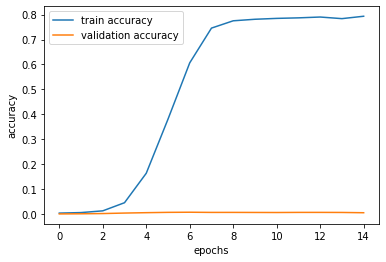

In [59]:
plot_accuracy(epochs, history)

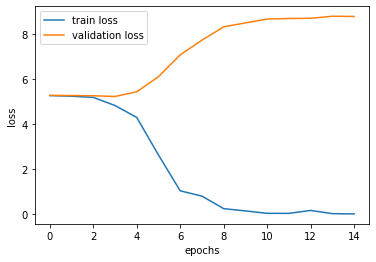

In [62]:
plot_loss(epochs, history)

In [61]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,5.2676,5.278194,0.004325,0.001076
1,5.2400,5.271002,0.006443,0.001597
2,5.1874,5.261649,0.013370,0.002548
3,4.8272,5.227630,0.045980,0.004504
4,4.2960,5.436451,0.164070,0.006048
5,2.6284,6.108027,0.380887,0.007340
6,1.0392,7.076733,0.606640,0.007842
7,0.8030,7.729330,0.745890,0.007106
8,0.2474,8.321421,0.775162,0.007160
9,0.1464,8.495086,0.781299,0.006945


From the results we gather that the addition of augmentations did not assist us in the improvement of our model.

We can try the following suggestions to improve our model:

1. We can try and to train our model on the unmodified data (e.g. without cropping).

2. We can try and add the original uncropped images to the training set and train our model on twice the size of samples.

3. We can try and swap out our flattening and max pooling with an adaptive average pooling.

## The Final Model

As the second architecture yielded the best results, we will use it as our final model architecture as well and measure its full metrics.

### Defining the architecture

In [31]:
model = ConvNetV2(channels, height, width, 3).to(device)

Setting Model Train Function

In [30]:
def train_and_test(train_dataset, test_dataset, epochs, batch_size, learning_rate, loss_fn):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  history = []
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  for epoch in range(epochs):
    print("epoch: ", epoch+1, "/", epochs)
    train_loss, train_acc = train_loop(train_loader, model, device, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_loader, model, device, loss_fn)
    history.append({'train_loss':train_loss.detach().cpu().numpy(), 'val_loss':test_loss, 'train_acc':train_acc, 'val_acc':test_acc})
    print()

  test_loss, test_acc = test_loop(test_loader, model, device, loss_fn)
  return history

### Results

In [31]:
history = train_and_test(cropped_cars_train_dataset, cropped_cars_test_dataset, epochs, batch_size, learning_rate, loss_fn)

epoch:  1 / 15
loss=5.291, 0 samples / 8144
loss=5.282, 800 samples / 8144
loss=5.285, 1600 samples / 8144
loss=5.272, 2400 samples / 8144
loss=5.295, 3200 samples / 8144
loss=5.256, 4000 samples / 8144
loss=5.326, 4800 samples / 8144
loss=5.310, 5600 samples / 8144
loss=5.153, 6400 samples / 8144
loss=5.158, 7200 samples / 8144
loss=5.055, 8000 samples / 8144
train accuracy = 0.00577112
test accuracy = 0.010073373958462879, test loss = 5.207495

epoch:  2 / 15
loss=5.086, 0 samples / 8144
loss=5.303, 800 samples / 8144
loss=5.271, 1600 samples / 8144
loss=4.984, 2400 samples / 8144
loss=5.209, 3200 samples / 8144
loss=4.949, 4000 samples / 8144
loss=5.021, 4800 samples / 8144
loss=5.324, 5600 samples / 8144
loss=5.234, 6400 samples / 8144
loss=5.021, 7200 samples / 8144
loss=5.183, 8000 samples / 8144
train accuracy = 0.01583988
test accuracy = 0.02499689093396344, test loss = 5.094952

epoch:  3 / 15
loss=5.023, 0 samples / 8144
loss=5.033, 800 samples / 8144
loss=4.758, 1600 samples

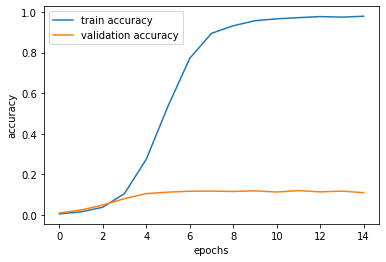

In [32]:
plot_accuracy(epochs, history)

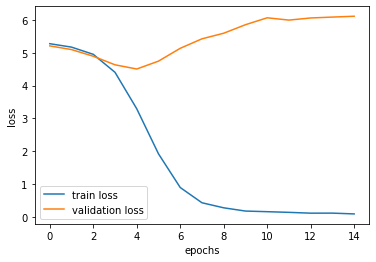

In [33]:
plot_loss(epochs, history)

In [34]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,5.274221,5.207495,0.005771,0.010073
1,5.1697984,5.094952,0.015840,0.024997
2,4.9502606,4.891859,0.038679,0.049496
3,4.402196,4.630991,0.106090,0.080960
4,3.2900712,4.502672,0.274681,0.105833
5,1.9172872,4.743171,0.535977,0.113046
6,0.8907333,5.134113,0.771611,0.117523
7,0.4258316,5.422966,0.894646,0.118145
8,0.2723634,5.593611,0.931974,0.116279
9,0.17319192,5.852866,0.956778,0.119388


# **Adding Inference-Time-Augmentation**

We will save the augmented samples along with their original versions in a different folder so we can alternate between datasets in case we are not interested in using the augmented dataset.

In [35]:
resize_images(test_path, test_annos_path, processed_test_path)
processed_cars_test_dataset = cars_dataset(processed_test_path, y_test_labels_path)

In [36]:
def aug_generator(sample_img):
  sample_img = sample_img.numpy()
  sample_img = sample_img.transpose()
  sample_img = sample_img.astype(np.uint8)

  transforms = [
      iaa.Fliplr(0.7), iaa.Affine(rotate=10), iaa.CropAndPad(percent=(-0.25, 0.25))
  ]
  transformed = []
  for transform in transforms:
    transformed_image = transform(image=sample_img)
    transformed_image = transformed_image.transpose()
    transformed_image = transformed_image.astype(np.float32)
    transformed_image = torch.from_numpy(transformed_image)
    transformed.append(transformed_image)
  return transformed

Before augmentation

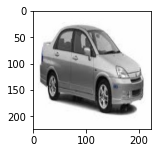

In [38]:
sample_img, label = processed_cars_test_dataset.__getitem__(0)
sample_img = sample_img.transpose()
sample_img = sample_img.astype(np.uint8)
fig = plt.figure(figsize=(10, 10))
plt.subplot(4, 4, 1)
plt.imshow(sample_img)

After augmentation

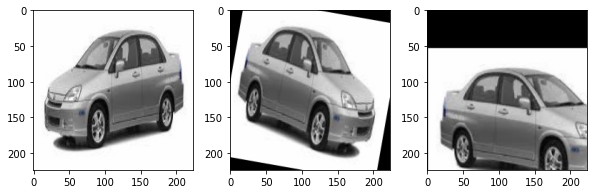

In [40]:
im, l = processed_cars_test_dataset.__getitem__(0)

fig = plt.figure(figsize=(10, 10))
im = torch.from_numpy(im)
generated = aug_generator(im)
for idx,transformed_image in enumerate(generated):
  transformed_image = transformed_image.numpy()
  transformed_image = transformed_image.transpose()
  transformed_image = transformed_image.astype(np.uint8)
  plt.subplot(3, 3, (1+idx))
  plt.imshow(transformed_image)
plt.show()

redefining test loop so each image will be augmentated

In [41]:
def get_img_TTA_mean(im,model):
  mean_results = [0 for i in range(196)]
  aug_imgs = aug_generator(im)
  imgs = []

  for img in aug_imgs:

    imgs.append(img)
  for idx , image in enumerate(imgs):
    image = image.to(device)
    preds = model(image)[0]


    if idx == 0:
      mean_pred = preds
    else:
      for label in range(len(preds)):
        mean_pred[label] += preds[label]

  for i in range(len(mean_pred)):
    mean_pred[i] /= len(imgs)

  return mean_pred.argmax(0)

In [42]:
def test_loop_TTA(data_loader, model, device, loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0
    true_positives=0
    with torch.no_grad():
        for X,y in data_loader:
            y = y.to(dtype=torch.long)
            for idx,im in enumerate(X):
              pred = get_img_TTA_mean(im,model)

              if y[idx] == pred:
                true_positives += 1
     
    test_acc = true_positives/size
    print(f'test accuracy = {test_acc}')
    return test_loss, test_acc

## Results

In [43]:
processed_cars_test_dataset = cars_dataset(processed_test_path, y_test_labels_path)
test_loader = DataLoader(processed_cars_test_dataset, batch_size=batch_size, shuffle=True)
test_loss, test_acc = test_loop_TTA(test_loader, model, device, loss_fn)
test_res = [{'test_loss':test_loss, 'test_acc':test_acc}]
test_res_dataframe = pd.DataFrame(test_res)
test_res_dataframe

test accuracy = 0.0747419475189653


,test_loss,test_acc
0,0,0.074742


# **Adding a new category**

Adding 'Tesla Model 3' to the dataset

In [44]:
resize_images(extra_train_path, train_annos_path, cropped_train_path, crop=False)
resize_images(extra_test_path, test_annos_path, cropped_test_path, crop=False)

Redefining the model to reset existing weights

In [30]:
model = ConvNetV2(channels, height, width, 3).to(device)

We have to modify the final layer in our model to fit the output to the new amount of classes (196->197).

In [31]:
model.fc2 = nn.Linear(1000, 197).to(device)

## Results

In [32]:
history = train_and_test(cropped_cars_train_dataset, cropped_cars_test_dataset, epochs, batch_size, learning_rate, loss_fn)

epoch:  1 / 15
loss=5.251, 0 samples / 8144
loss=5.218, 800 samples / 8144
loss=5.263, 1600 samples / 8144
loss=5.245, 2400 samples / 8144
loss=5.329, 3200 samples / 8144
loss=5.299, 4000 samples / 8144
loss=5.259, 4800 samples / 8144
loss=5.093, 5600 samples / 8144
loss=5.273, 6400 samples / 8144
loss=5.316, 7200 samples / 8144
loss=5.215, 8000 samples / 8144
train accuracy = 0.00761297
test accuracy = 0.015296604899888074, test loss = 5.217273

epoch:  2 / 15
loss=5.271, 0 samples / 8144
loss=5.382, 800 samples / 8144
loss=5.248, 1600 samples / 8144
loss=5.308, 2400 samples / 8144
loss=5.278, 3200 samples / 8144
loss=5.305, 4000 samples / 8144
loss=4.886, 4800 samples / 8144
loss=5.282, 5600 samples / 8144
loss=5.324, 6400 samples / 8144
loss=5.216, 7200 samples / 8144
loss=5.250, 8000 samples / 8144
train accuracy = 0.01534872
test accuracy = 0.025494341499813455, test loss = 5.087288

epoch:  3 / 15
loss=4.975, 0 samples / 8144
loss=5.077, 800 samples / 8144
loss=4.697, 1600 sample

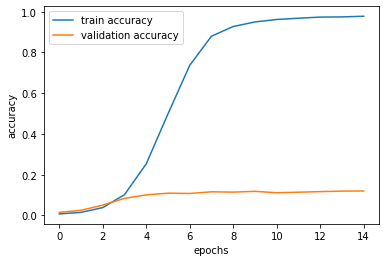

In [33]:
plot_accuracy(epochs,history)

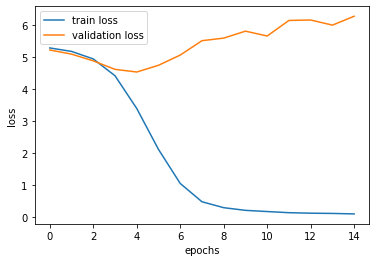

In [34]:
plot_loss(epochs,history)

In [35]:
history_dataframe = pd.DataFrame(history)
history_dataframe

,train_loss,val_loss,train_acc,val_acc
0,5.281345,5.217273,0.007613,0.015297
1,5.1727276,5.087288,0.015349,0.025494
2,4.9377537,4.877318,0.038556,0.050740
3,4.411532,4.611954,0.102161,0.083945
4,3.3882606,4.528798,0.253561,0.101107
5,2.109445,4.739199,0.498895,0.109315
6,1.0454562,5.058652,0.736861,0.107947
7,0.47362393,5.507739,0.879912,0.116155
8,0.28844383,5.588275,0.927308,0.114538
9,0.20497681,5.806097,0.949779,0.118393


# **Transfer Learning**

We chose to use resnet18 as our pretrained model. 



Because our pre-trained model already has weigths trained on ImageNet samples, we wouldn't like to change its weights at the beginning. So here we will freeze all the model's gradients except for the last layer we added and train the last layer on its own on our train data set.


In [68]:
from torchvision.models import resnet18, ResNet18_Weights

# learning rate
learning_rate = 1e-3

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Number of classes in the dataset
num_classes = 197

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

pretrained_model = resnet18()

def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(pretrained_model, feature_extract)

pretrained_model.fc = nn.Linear(512, num_classes)

## Training FC layer 

In [69]:
cropped_cars_train_dataset = cars_dataset(cropped_train_path, y_train_labels_path)
cropped_cars_test_dataset = cars_dataset(cropped_test_path, y_test_labels_path)

In [70]:
train_subsampler = torch.utils.data.SubsetRandomSampler([i for i in range(cropped_cars_train_dataset.__len__())])
train_loader = DataLoader(processed_train_path, batch_size, train_subsampler)

In [39]:
def train(model, dataset, epochs, batch_size, learning_rate, loss_fn): 
  history = []
  train_subsampler = torch.utils.data.SubsetRandomSampler([i for i in range(dataset.__len__())])
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler= train_subsampler)
  for epoch in range(epochs):
    print("epoch: ", epoch+1, "/", epochs)
    train_loss, train_acc = train_loop(train_loader, model, device, loss_fn, optimizer)
    history.append({'train_loss':train_loss.detach().cpu().numpy(), 'train_acc':train_acc})

    print()

  return history

train(pretrained_model, cars_train_dataset, epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, loss_fn=loss_fn)

epoch:  1 / 30
loss=5.460, 0 samples / 8144
loss=5.729, 3200 samples / 8144
loss=5.373, 6400 samples / 8144
train accuracy = 0.00834971

epoch:  2 / 30
loss=5.346, 0 samples / 8144
loss=5.544, 3200 samples / 8144
loss=5.435, 6400 samples / 8144
train accuracy = 0.00822692

epoch:  3 / 30
loss=5.155, 0 samples / 8144
loss=5.529, 3200 samples / 8144
loss=5.339, 6400 samples / 8144
train accuracy = 0.01461198

epoch:  4 / 30
loss=5.122, 0 samples / 8144
loss=5.211, 3200 samples / 8144
loss=5.230, 6400 samples / 8144
train accuracy = 0.01596267

epoch:  5 / 30
loss=5.030, 0 samples / 8144
loss=5.203, 3200 samples / 8144
loss=5.280, 6400 samples / 8144
train accuracy = 0.01915521

epoch:  6 / 30
loss=5.284, 0 samples / 8144
loss=5.270, 3200 samples / 8144
loss=4.997, 6400 samples / 8144
train accuracy = 0.02333006

epoch:  7 / 30
loss=4.913, 0 samples / 8144
loss=5.473, 3200 samples / 8144
loss=5.293, 6400 samples / 8144
train accuracy = 0.02357564

epoch:  8 / 30
loss=5.293, 0 samples / 81

[{'train_loss': array(5.493804, dtype=float32),
  'train_acc': 0.008349705304518664},
 {'train_loss': array(5.38616, dtype=float32),
  'train_acc': 0.008226915520628684},
 {'train_loss': array(5.3356915, dtype=float32),
  'train_acc': 0.014611984282907662},
 {'train_loss': array(5.285182, dtype=float32),
  'train_acc': 0.015962671905697445},
 {'train_loss': array(5.2533655, dtype=float32),
  'train_acc': 0.019155206286836934},
 {'train_loss': array(5.1909685, dtype=float32),
  'train_acc': 0.023330058939096267},
 {'train_loss': array(5.15503, dtype=float32),
  'train_acc': 0.023575638506876228},
 {'train_loss': array(5.1212425, dtype=float32),
  'train_acc': 0.02787328094302554},
 {'train_loss': array(5.078077, dtype=float32),
  'train_acc': 0.03131139489194499},
 {'train_loss': array(5.045804, dtype=float32),
  'train_acc': 0.029101178781925342},
 {'train_loss': array(5.0184107, dtype=float32),
  'train_acc': 0.0343811394891945},
 {'train_loss': array(4.971098, dtype=float32),
  'trai

## Test Results

In [40]:
test_loader = DataLoader(cars_test_dataset, batch_size=batch_size, shuffle=True)
test_loss, test_acc = test_loop(test_loader, pretrained_model, device, loss_fn)

test accuracy = 0.026862330555901006, test loss = 5.180982


## Fine Tuning
After training our new fully connected layer, we will unfreeze our model's gradients in order to train it for our dataset.

In [41]:
num_epochs = 18
for param in pretrained_model.parameters():
  param.requires_grad = True
train(pretrained_model, cropped_cars_train_dataset, epochs=num_epochs, batch_size=batch_size, learning_rate=0.01, loss_fn=loss_fn)

epoch:  1 / 18
loss=4.311, 0 samples / 8144
loss=5.307, 3200 samples / 8144
loss=5.164, 6400 samples / 8144
train accuracy = 0.00908644

epoch:  2 / 18
loss=5.230, 0 samples / 8144
loss=5.203, 3200 samples / 8144
loss=4.997, 6400 samples / 8144
train accuracy = 0.01682220

epoch:  3 / 18
loss=5.134, 0 samples / 8144
loss=5.160, 3200 samples / 8144
loss=4.913, 6400 samples / 8144
train accuracy = 0.02480354

epoch:  4 / 18
loss=4.730, 0 samples / 8144
loss=4.775, 3200 samples / 8144
loss=4.984, 6400 samples / 8144
train accuracy = 0.03438114

epoch:  5 / 18
loss=5.138, 0 samples / 8144
loss=4.999, 3200 samples / 8144
loss=4.654, 6400 samples / 8144
train accuracy = 0.04322200

epoch:  6 / 18
loss=4.523, 0 samples / 8144
loss=4.509, 3200 samples / 8144
loss=4.532, 6400 samples / 8144
train accuracy = 0.05832515

epoch:  7 / 18
loss=4.307, 0 samples / 8144
loss=4.414, 3200 samples / 8144
loss=4.125, 6400 samples / 8144
train accuracy = 0.07748035

epoch:  8 / 18
loss=4.617, 0 samples / 81

[{'train_loss': array(5.594163, dtype=float32),
  'train_acc': 0.009086444007858546},
 {'train_loss': array(5.115736, dtype=float32),
  'train_acc': 0.016822200392927308},
 {'train_loss': array(5.0125527, dtype=float32),
  'train_acc': 0.02480353634577603},
 {'train_loss': array(4.909724, dtype=float32),
  'train_acc': 0.0343811394891945},
 {'train_loss': array(4.7917786, dtype=float32),
  'train_acc': 0.043222003929273084},
 {'train_loss': array(4.608514, dtype=float32),
  'train_acc': 0.05832514734774067},
 {'train_loss': array(4.375958, dtype=float32),
  'train_acc': 0.0774803536345776},
 {'train_loss': array(4.1099195, dtype=float32),
  'train_acc': 0.10424852652259332},
 {'train_loss': array(3.7329197, dtype=float32),
  'train_acc': 0.15238212180746563},
 {'train_loss': array(3.2903438, dtype=float32),
  'train_acc': 0.21635559921414538},
 {'train_loss': array(2.7349281, dtype=float32),
  'train_acc': 0.3094302554027505},
 {'train_loss': array(2.174664, dtype=float32),
  'train_ac

In [42]:
test_loss, test_acc = test_loop(test_loader, pretrained_model, device, loss_fn)

test accuracy = 0.3625170998632011, test loss = 3.586257


The model is misclassifying because of underfitting

Suggestions for improvement:


1.   Reduce learning rate
2.   Extend the fully connected layer



## Experiment Summary Table

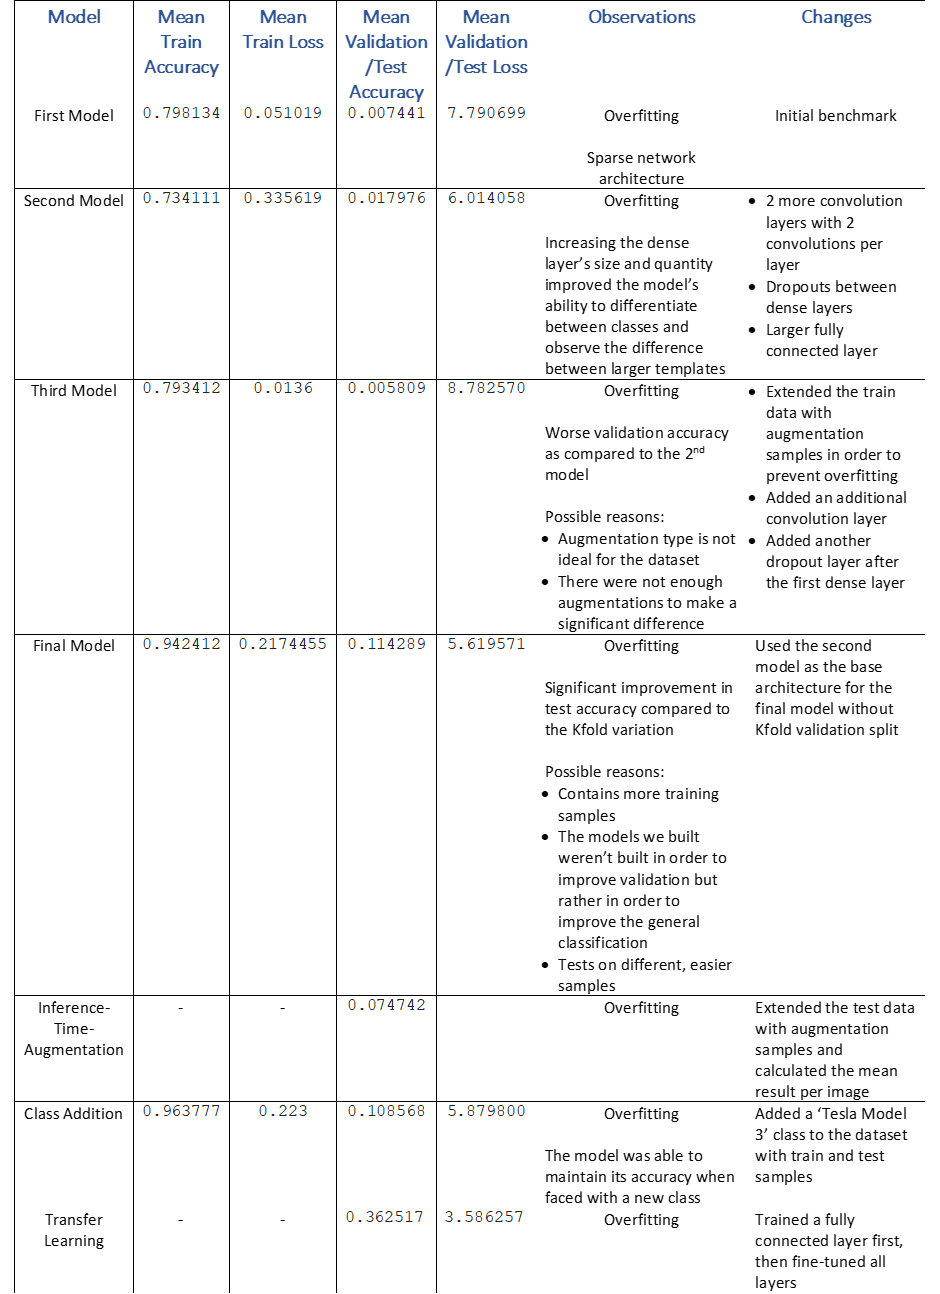

# **Final Report**

Before beginning your work on a model, it is important to first get to know the dataset you are going to work with.
The cars dataset is pretty balanced with a similar amount of samples per class of varying sizes. This means that the most important step is to first resize the images to a common size.
From the benchmarks published we can assess that training a model from scratch on this dataset yields mostly sub-par results. The most successful classifications are done via transfer training on pretrained models.

Our initial model implementation and training resulted in over fitting with very low validation accuracy and increasing loss. To improve upon this result we suggested various ways to tackle the problem, the important of which are:
An addition of another fully connected layer before the prediction layer with a larger amount of in and out features can help the model to be more specific with its output which in turn will allow the last layer to classify the data based on more features.
The addition of more dropouts in between layers will add another layer of randomization to our model which will "force" it to generalize the input data more instead of memorizing it.


When using inference time augmentation it is imperative to be acquainted with your dataset and the goal your model is trying to achieve. Applying augmentations that are relevant to your dataset is the key to making good use of this method.

Transfer learning could save a lot of time and yield good results but it isn't trivial. One must find a good learning fit, use fine tuning and select an appropriate pretrained model that fits the dataset. A model that was trained on data that contains similarities to our own data. The size of our dataset is also important for fine tuning the model to it.